In [1]:
# =============================================================================
# PART 1: SETUP, DATA LOADING & CUSTOM TRANSFORMERS
# -----------------------------------------------------------------------------
# This section contains all necessary imports and loads the initial dataset.
# Most importantly, it defines the powerful, custom scikit-learn transformers
# from your original code. These will be the building blocks of our feature
# engineering pipeline.
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from category_encoders import TargetEncoder
import warnings
import shap

# --- Setup ---
# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')
# Set a consistent plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)
# Set a random seed for reproducibility
RANDOM_STATE = 42

# --- Data Loading ---
print("PART 1: Loading and preparing data...")
try:
    # This uses your real dataset. Ensure the path is correct.
    df = pd.read_csv('/Users/shayan/Desktop/IDS2/Stattkueche/df_weather2.csv', parse_dates=['DateOfService', 'DateOfOrder', 'DateOfCancel'])
    print("Successfully loaded df_weather2.csv.")
except FileNotFoundError:
    print("FATAL ERROR: df_weather2.csv not found. Please update the file path.")
    exit()

# --- Initial Feature Creation ---
# This is the target variable for the final regression model.
df['net_qty'] = df['OrderQty'] - df['CanceledQty']
print("Initial DataFrame shape:", df.shape)
display(df.head())


# --- Custom Transformer Definitions (from your original code) ---
# We define all your custom classes here to be used later in the pipeline.

class HistCancelRateTransformer(BaseEstimator, TransformerMixin):
    """
    Calculates the historical mean of a value column, grouped by specified keys.
    This is used to create features like the historical cancellation rate for a
    given Site/Menu combination.
    """
    def __init__(self, group_keys=('Site','MenuBase'), value_col='net_qty', out_col='hist_cancel_rate'):
        self.group_keys = group_keys
        self.value_col  = value_col
        self.out_col    = out_col
    def fit(self, X, y=None):
        keys = list(self.group_keys)
        # Calculate the mean for each group and a global median for fallback
        self.hist_    = X.groupby(keys)[self.value_col].mean()
        self.default_ = self.hist_.median()
        return self
    def transform(self, X):
        keys   = list(self.group_keys)
        tuples = [tuple(r) for r in X[keys].values]
        X_copy = X.copy()
        # Map the historical mean to each row
        X_copy[self.out_col] = [self.hist_.get(t, self.default_) for t in tuples]
        return X_copy

class ClusterTransformer(BaseEstimator, TransformerMixin):
    """
    Groups data into clusters based on their feature profiles using K-Means.
    This helps the model identify types of orders (e.g., high-cancellation menus).
    """
    def __init__(self, profile_feats, group_keys=('Site','MenuBase'),
                 n_clusters=5, out_col='cluster_id'):
        self.profile_feats = profile_feats
        self.group_keys    = group_keys
        self.n_clusters    = n_clusters
        self.out_col       = out_col
    def fit(self, X, y=None):
        keys = list(self.group_keys)
        # Create profiles by averaging features for each group
        prof = (X.groupby(keys)[self.profile_feats].mean().reset_index())
        prof[self.profile_feats] = prof[self.profile_feats].fillna(prof[self.profile_feats].median())

        # Scale profiles and fit K-Means
        self.scaler_ = StandardScaler().fit(prof[self.profile_feats])
        scaled      = self.scaler_.transform(prof[self.profile_feats])
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=RANDOM_STATE).fit(scaled)

        # Create a mapping from group to cluster ID
        tuples      = [tuple(r) for r in prof[keys].values]
        self.cluster_map_ = dict(zip(tuples, self.kmeans_.labels_))
        self.default_     = int(np.median(self.kmeans_.labels_))
        return self
    def transform(self, X):
        X_copy = X.copy()
        keys   = list(self.group_keys)
        tuples = [tuple(r) for r in X_copy[keys].values]
        # Assign cluster ID to each row
        X_copy[self.out_col] = [self.cluster_map_.get(t, self.default_) for t in tuples]
        return X_copy

class InCVTargetEncoder(BaseEstimator, TransformerMixin):
    """
    A target encoder that calculates encodings within cross-validation folds
    to prevent data leakage.
    """
    def __init__(self, cols, smoothing=1.0):
        self.cols = cols
        self.smoothing = smoothing
    def fit(self, X, y):
        self.global_mean_ = y.mean()
        self.mapping_ = {}
        for c in self.cols:
            df_temp = pd.DataFrame({c: X[c], 'target': y})
            agg = df_temp.groupby(c)['target'].agg(['mean', 'count'])
            agg['enc'] = ((agg['count'] * agg['mean'] + self.smoothing * self.global_mean_) /
                          (agg['count'] + self.smoothing))
            self.mapping_[c] = agg['enc']
        return self
    def transform(self, X):
        X_copy = X.copy()
        for c in self.cols:
            X_copy[c + '_te'] = X_copy[c].map(self.mapping_[c]).fillna(self.global_mean_)
        return X_copy

class MissingFlagImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing values for numeric columns and adds a flag column
    indicating where the imputation occurred.
    """
    def __init__(self, strategy='median'):
        self.strategy = strategy
    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes(include=np.number).columns
        clean = X[self.num_cols].replace([np.inf, -np.inf], np.nan)
        self.imputer_ = SimpleImputer(strategy=self.strategy).fit(clean)
        return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.num_cols] = X_copy[self.num_cols].replace([np.inf, -np.inf], np.nan)
        for c in self.num_cols:
            if X_copy[c].isna().any():
                X_copy[c + '_missing'] = X_copy[c].isna().astype(int)
        X_copy[self.num_cols] = self.imputer_.transform(X_copy[self.num_cols])
        return X_copy

class ColumnDropper(BaseEstimator, TransformerMixin):
    """A simple transformer to drop specified columns from a DataFrame."""
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=self.cols_to_drop, errors='ignore')

print("\nPART 1 Complete: All necessary libraries and custom classes are defined.")


/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PART 1: Loading and preparing data...
Successfully loaded df_weather2.csv.
Initial DataFrame shape: (4966796, 41)


,Unnamed: 0,DateOfOrder,OrderId,TransactionId,DateOfService,OrderQty,MenuName,MenuPrice,MenuSubsidy,BookingNr,...,morning,afternoon,evening,hist_cancel_rate,is_holiday,tavg_C,prcp_mm,rain_flag,temp_dev,cancel_timing
0,0,2019-12-02 20:39:46,11161800,5fff5813ae674809a06e3b1fe5528fcf,2020-01-02,1,Mittagessen (BS),3.05,0.0,474-136052114,...,0,0,1,1.0499,0,0.3,0.0,0,-3.965782,no_cancel
1,1,2019-12-02 20:39:46,11161801,7c4f0e97356e46669abefe8dc5fb0ff0,2020-01-03,1,Mittagessen (BS),3.05,0.0,474-136052114,...,0,0,1,1.0499,0,6.7,4.9,1,2.434218,no_cancel
2,2,2019-12-03 22:29:24,11166739,ee1d1a4a7458414a8bb420111ba0fa8c,2020-01-02,1,Mittagessen (BS),3.05,0.0,474-136060130,...,0,0,1,1.0499,0,0.3,0.0,0,-3.965782,no_cancel
3,3,2019-12-04 13:27:22,11169532,86497dc4e7434b838a335c439325fb65,2020-01-02,1,Mittagessen (BS),3.05,0.0,474-136047096,...,0,1,0,1.0499,0,0.3,0.0,0,-3.965782,no_cancel
4,4,2019-12-04 13:27:22,11169533,6054345ad0b14bd297dbdc6372ff1488,2020-01-03,1,Mittagessen (BS),3.05,0.0,474-136047096,...,0,1,0,1.0499,0,6.7,4.9,1,2.434218,no_cancel



PART 1 Complete: All necessary libraries and custom classes are defined.



PART 2: Aggregating data to daily level for regression forecasting...
Data successfully aggregated to daily level:


,Site,net_qty,OrderQty,CanceledQty,MenuPrice,MenuSubsidy,tavg_C,prcp_mm,rain_flag,temp_dev,is_holiday,is_weekend,MenuBase,SchoolID,hist_cancel_rate,daily_cancel_pct
DateOfService,,,,,,,,,,,,,,,,
2020-01-02,BK,32,32,0,1.812500,1.687500,1.2,0.0,0,-2.957672,0,0,1,1,0.979676,0.0
2020-01-02,LP,169,169,0,2.832530,0.240964,0.3,0.0,0,-3.965782,1,1,1,2,1.049900,0.0
2020-01-03,BK,32,32,0,1.993750,1.506250,6.8,201.6,1,2.642328,0,0,1,1,0.979676,0.0
2020-01-03,LP,184,184,0,2.714088,0.334530,6.7,886.9,1,2.434218,1,1,1,2,1.049900,0.0
2020-01-04,LP,1,1,0,0.000000,3.500000,4.7,5.1,1,0.434218,0,0,1,1,1.049900,0.0



Performing EDA on the new daily dataset...


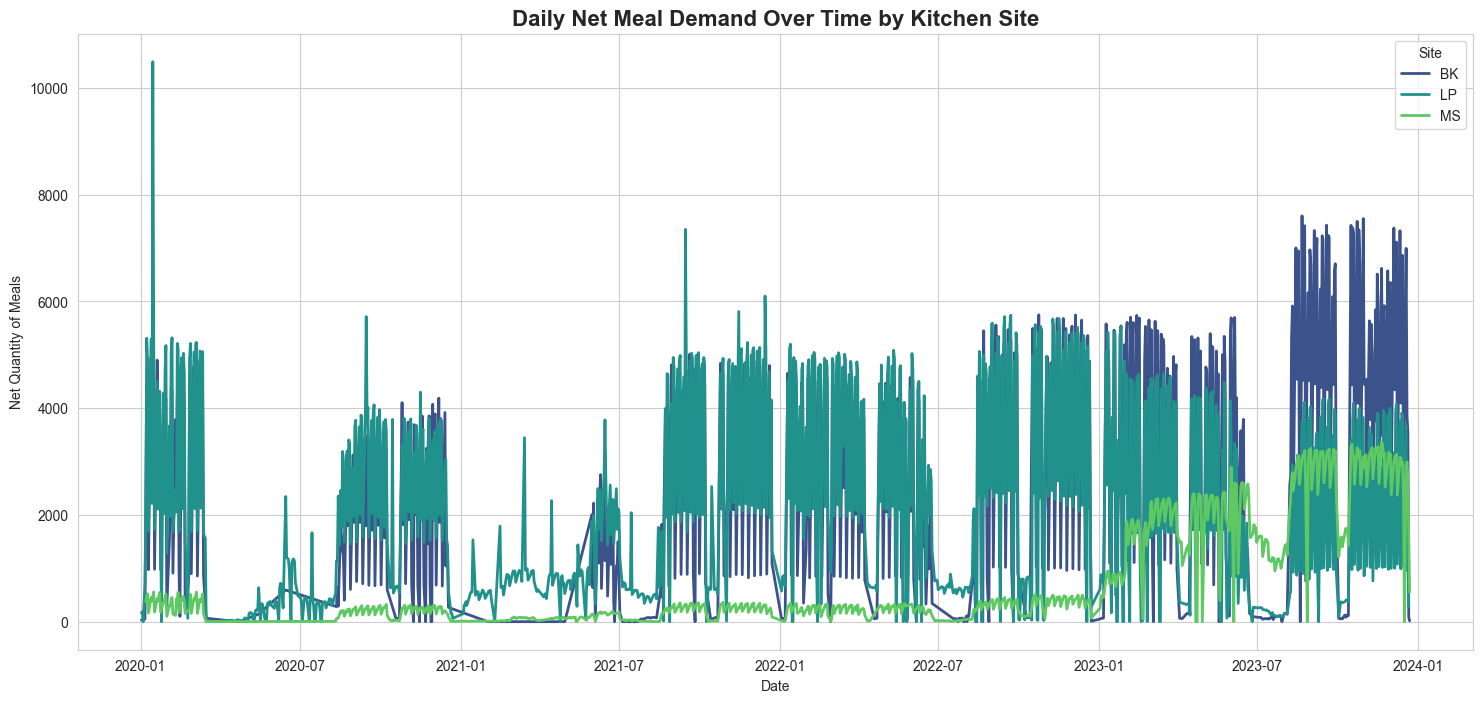

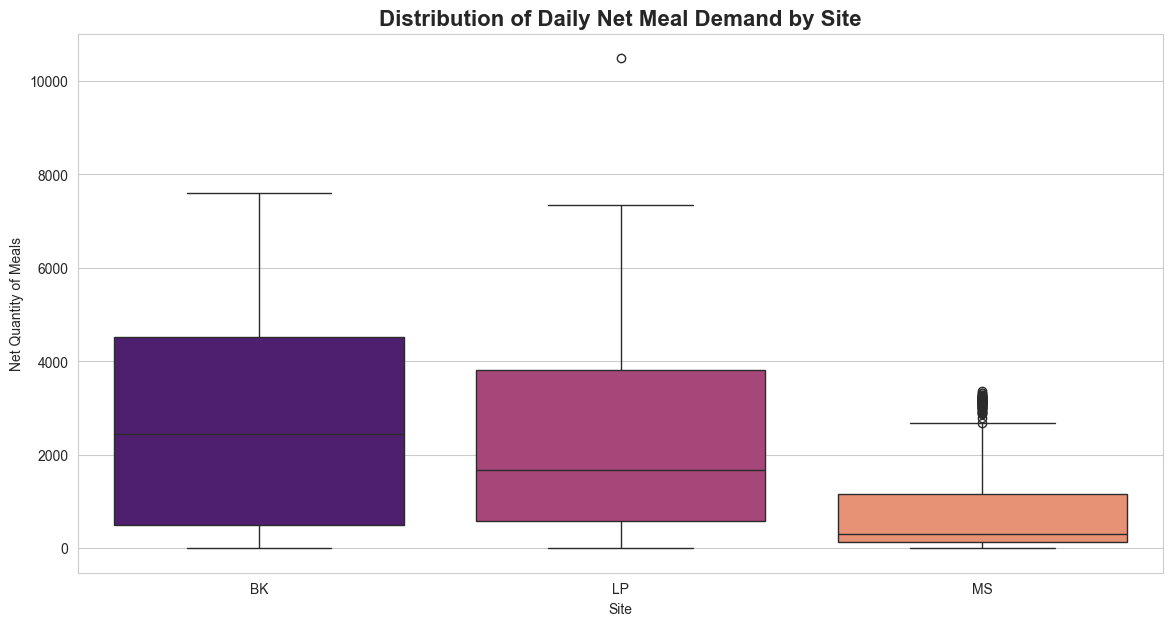


Checking for multicollinearity with VIF on daily aggregated data...
VIF Scores for Daily Features:


,feature,VIF
10,hist_cancel_rate,158.558061
0,MenuPrice,98.935076
1,MenuSubsidy,14.587172
7,is_weekend,13.318861
8,MenuBase,7.122768
2,tavg_C,5.504197
9,SchoolID,4.195988
4,rain_flag,2.259317
6,is_holiday,1.696190
3,prcp_mm,1.648579



Generating feature correlation heatmap...


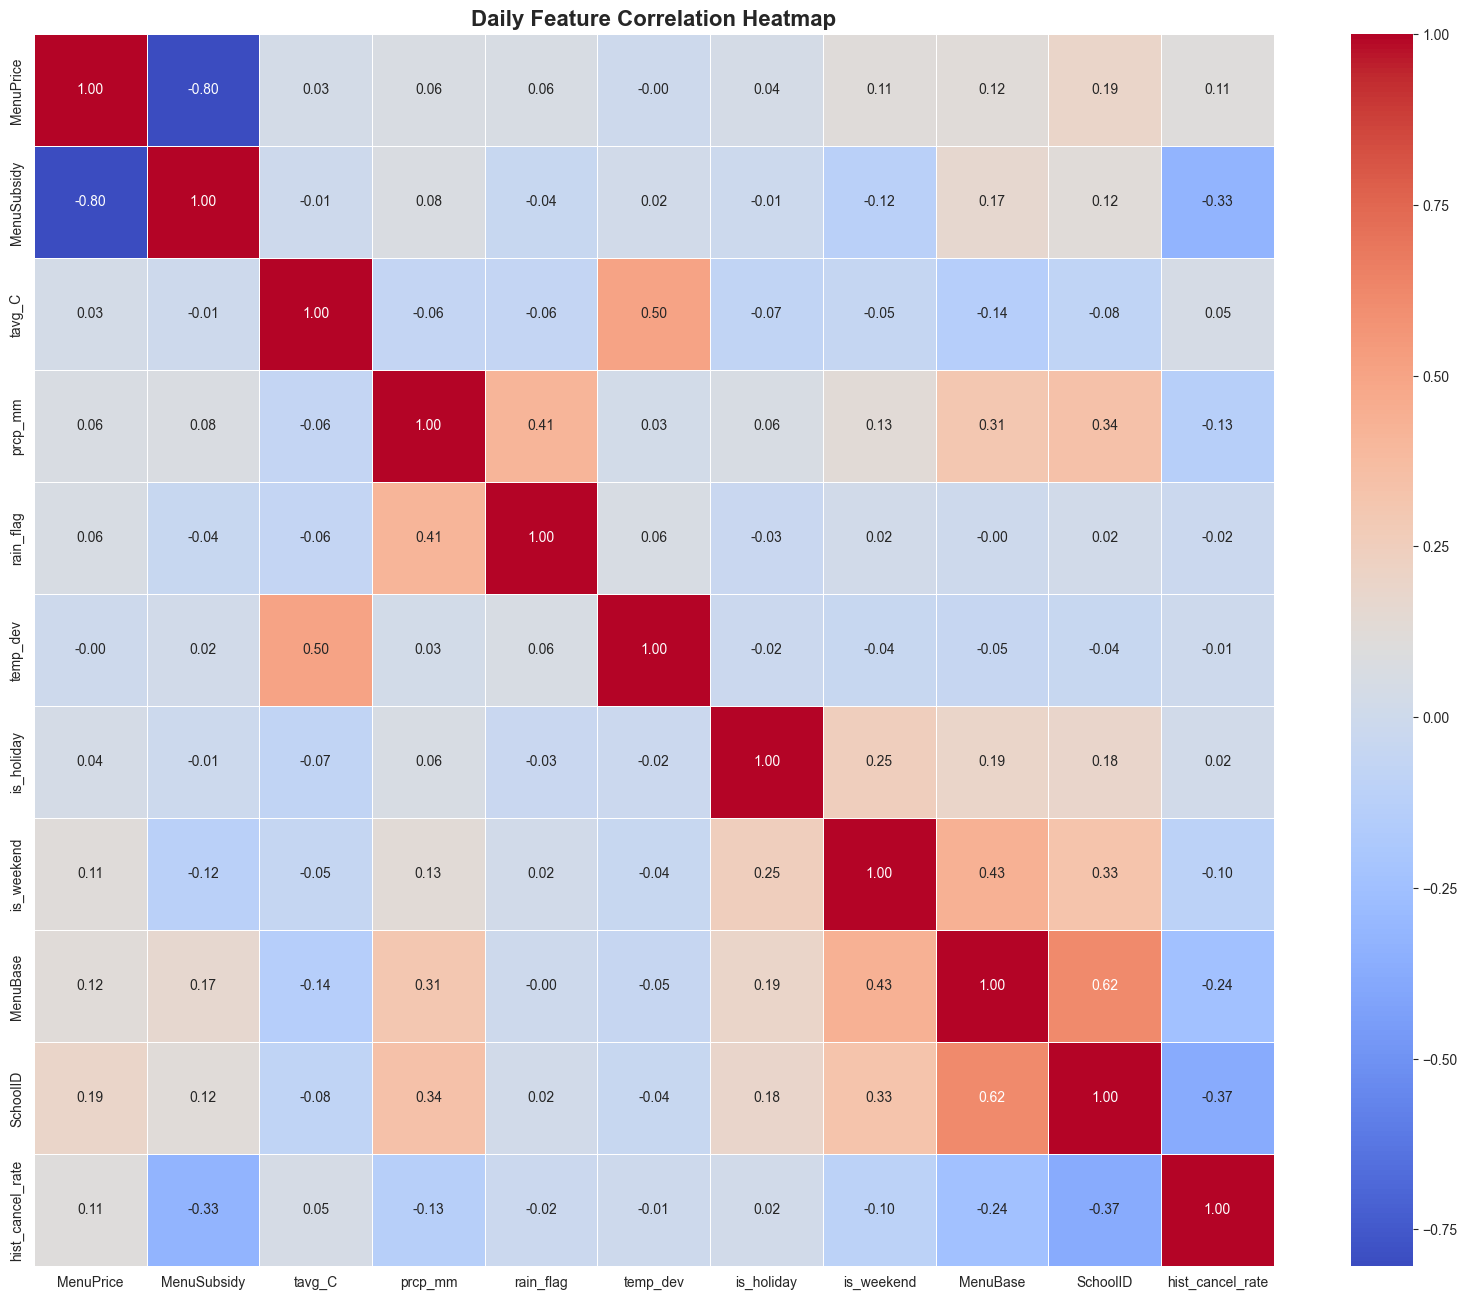


PART 2 Complete: Data aggregated and initial analysis performed.


In [2]:

print("\nPART 2: Aggregating data to daily level for regression forecasting...")

# --- Daily Aggregation ---
# Define how each column should be summarized to a daily value
agg_dict = {
    'net_qty': 'sum',
    'OrderQty': 'sum',
    'CanceledQty': 'sum',
    'MenuPrice': 'mean',
    'MenuSubsidy': 'mean',
    'tavg_C': 'mean',
    'prcp_mm': 'sum',
    'rain_flag': 'max',
    'temp_dev': 'mean',
    'is_holiday': 'max',
    'is_weekend': 'max',
    'MenuBase': 'nunique',
    'SchoolID': 'nunique',
    'hist_cancel_rate': 'mean'
}

# Group by date and kitchen site
df_daily = df.groupby(['DateOfService', 'Site']).agg(agg_dict).reset_index()

# Create new daily-level features from the aggregated data
# Handle potential division by zero if OrderQty is 0
df_daily['daily_cancel_pct'] = (df_daily['CanceledQty'] / df_daily['OrderQty']).fillna(0)

# Sort by date and set it as the index, which is best practice for time series data
df_daily = df_daily.sort_values('DateOfService').set_index('DateOfService')

print("Data successfully aggregated to daily level:")
display(df_daily.head())

# --- Exploratory Data Analysis (EDA) on Daily Data ---
print("\nPerforming EDA on the new daily dataset...")

# Plot 1: Daily Demand Over Time for Each Site
plt.figure(figsize=(18, 8))
sns.lineplot(data=df_daily, x=df_daily.index, y='net_qty', hue='Site', palette='viridis', lw=2)
plt.title('Daily Net Meal Demand Over Time by Kitchen Site', fontsize=16, weight='bold')
plt.ylabel('Net Quantity of Meals')
plt.xlabel('Date')
plt.legend(title='Site')
plt.show()

# Plot 2: Distribution of Daily Demand
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_daily, x='Site', y='net_qty', palette='magma')
plt.title('Distribution of Daily Net Meal Demand by Site', fontsize=16, weight='bold')
plt.ylabel('Net Quantity of Meals')
plt.xlabel('Site')
plt.show()

# --- VIF Analysis (adapted from your original code) ---
# This helps identify multicollinearity among our new daily features.
print("\nChecking for multicollinearity with VIF on daily aggregated data...")

# IMPORTANT: Exclude the target and its direct components to avoid leakage
leaky_cols = ['net_qty', 'OrderQty', 'CanceledQty', 'daily_cancel_pct']
numeric_features = df_daily.select_dtypes(include=np.number).drop(columns=leaky_cols)

# VIF requires no NaN values, so we'll create a temporary imputed version for the check
vif_data = numeric_features.copy()
vif_data.fillna(vif_data.median(), inplace=True) # Use median for a quick check

# Calculate VIF scores
vif_scores = pd.DataFrame()
vif_scores["feature"] = vif_data.columns
vif_scores["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

print("VIF Scores for Daily Features:")
display(vif_scores.sort_values('VIF', ascending=False))

# Plot 3: Feature Correlation Heatmap
print("\nGenerating feature correlation heatmap...")
plt.figure(figsize=(20, 16))
sns.heatmap(numeric_features.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Daily Feature Correlation Heatmap', fontsize=16, weight='bold')
plt.show()

print("\nPART 2 Complete: Data aggregated and initial analysis performed.")


In [5]:



# =============================================================================
# PART 3: FEATURE ENGINEERING PIPELINE AND MODEL DEFINITION
# -----------------------------------------------------------------------------
# This part defines the full data processing pipeline. It chains together
# transformers that create time-based features (lags, rolling averages),
# handle missing values, and drop unnecessary columns before feeding the
# data to the final regression model.
# =============================================================================

print("\nPART 3: Defining the feature engineering and regression pipeline...")

# --- Time-Based Feature Engineering Transformer ---
class DailyFeatureEngineer(BaseEstimator, TransformerMixin):
    """Creates time-based and lag features for the daily aggregated data."""
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything from the data, so fit is empty.
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        # Create basic time features
        X_copy['day_of_year'] = X_copy.index.dayofyear
        X_copy['weekday'] = X_copy.index.weekday
        X_copy['month'] = X_copy.index.month
        X_copy['year'] = X_copy.index.year
        X_copy['week_of_year'] = X_copy.index.isocalendar().week.astype(int)
        X_copy['quarter'] = X_copy.index.quarter

        # Create lag features (past demand)
        # We group by 'Site' to ensure lags are calculated correctly for each kitchen
        for lag in [1, 2, 7, 14, 28]:
            X_copy[f'lag_{lag}'] = X_copy.groupby('Site')['net_qty'].shift(lag)

        # Create rolling window features (trends)
        X_copy['rolling_mean_7'] = X_copy.groupby('Site')['net_qty'].shift(1).rolling(window=7, min_periods=1).mean()
        X_copy['rolling_std_7'] = X_copy.groupby('Site')['net_qty'].shift(1).rolling(window=7, min_periods=1).std()

        return X_copy

# --- Custom Scorer Definition ---
def asymmetric_loss(y_true, y_pred, under_penalty=1.2):
    """
    Calculates a custom loss where under-predictions are penalized more heavily.
    A lower score is better. This directly reflects the business goal.
    """
    error = y_true - y_pred
    # Apply penalty to under-predictions (where error is negative)
    loss = np.mean(np.where(error < 0, -error * under_penalty, error))
    return loss

# Convert the loss function into a scorer for use in scikit-learn's CV
# `greater_is_better=False` signifies that lower values of our loss are better.
asymmetric_scorer = make_scorer(asymmetric_loss, greater_is_better=False)

# --- Pipeline Assembly ---
# Define the columns to be dropped before the model sees the data.
# This is crucial for preventing data leakage.
features_to_exclude = ['net_qty', 'Site', 'OrderQty', 'CanceledQty', 'daily_cancel_pct']

# Assemble the full pipeline
# This chains all our data processing steps together.
# 1. 'daily_features': Creates lags, rolling windows, and date parts.
# 2. 'imputer': Handles missing values created by the lag/rolling features.
# 3. 'dropper': Removes the target and leaky columns.
# 4. 'regressor': The final Random Forest model that makes the prediction.
regression_pipeline = Pipeline([
    ('daily_features', DailyFeatureEngineer()),
    ('imputer', MissingFlagImputer(strategy='median')),
    ('dropper', ColumnDropper(cols_to_drop=features_to_exclude)),
    ('regressor', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

print("Successfully defined the regression pipeline and custom scorer.")
print("Pipeline Steps:", [step[0] for step in regression_pipeline.steps])

print("\nPART 3 Complete: Full regression pipeline is ready for training and evaluation.")



PART 3: Defining the feature engineering and regression pipeline...
Successfully defined the regression pipeline and custom scorer.
Pipeline Steps: ['daily_features', 'imputer', 'dropper', 'regressor']

PART 3 Complete: Full regression pipeline is ready for training and evaluation.



PART 4: Starting model training and evaluation for each site...

============================== Processing Site: BK ==============================
--> Evaluating model with time-series cross-validation...
    - Asymmetric Loss: 374.71 (+/- 161.17)
    - RMSE: 506.46 (+/- 259.36) meals
--> Fitting final pipeline on all data for this site...
--> Generating Actual vs. Predicted plot for the last fold...


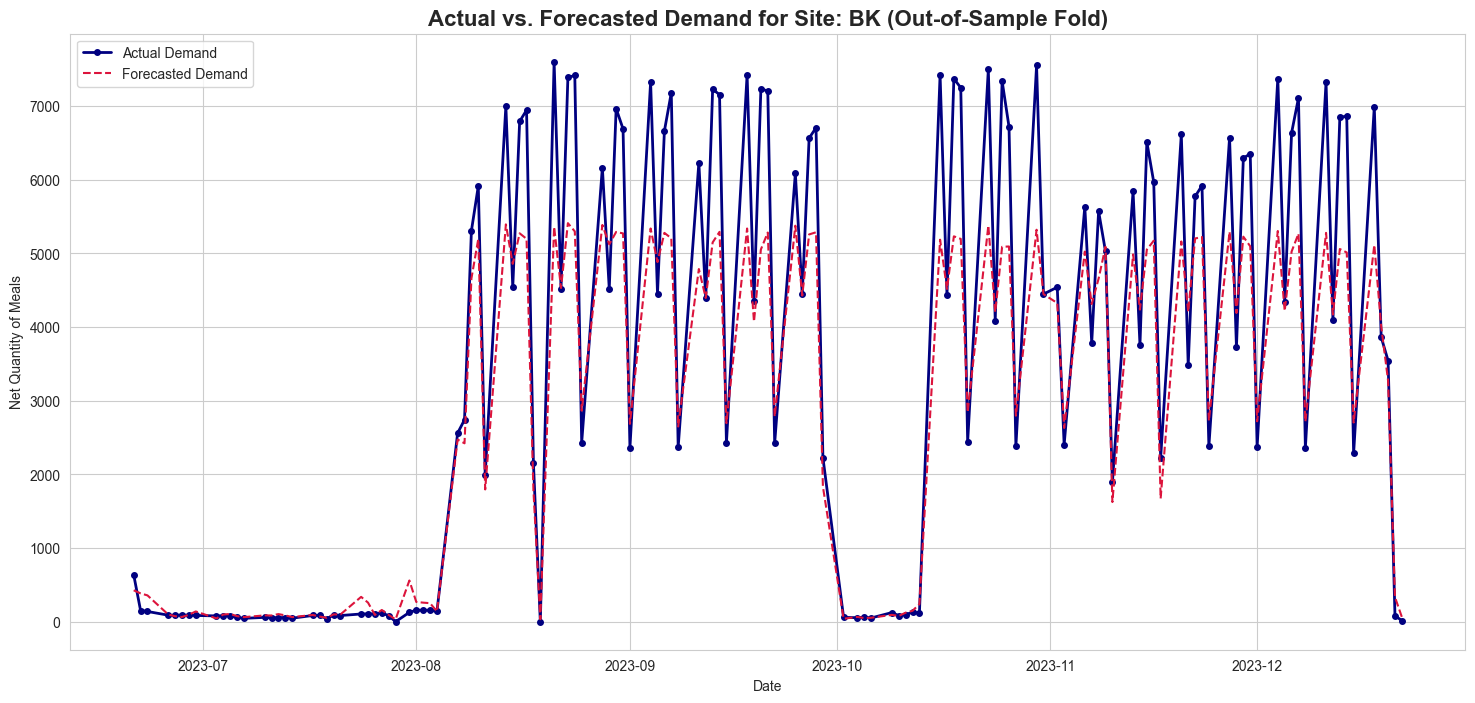

--> Generating Residuals plot...


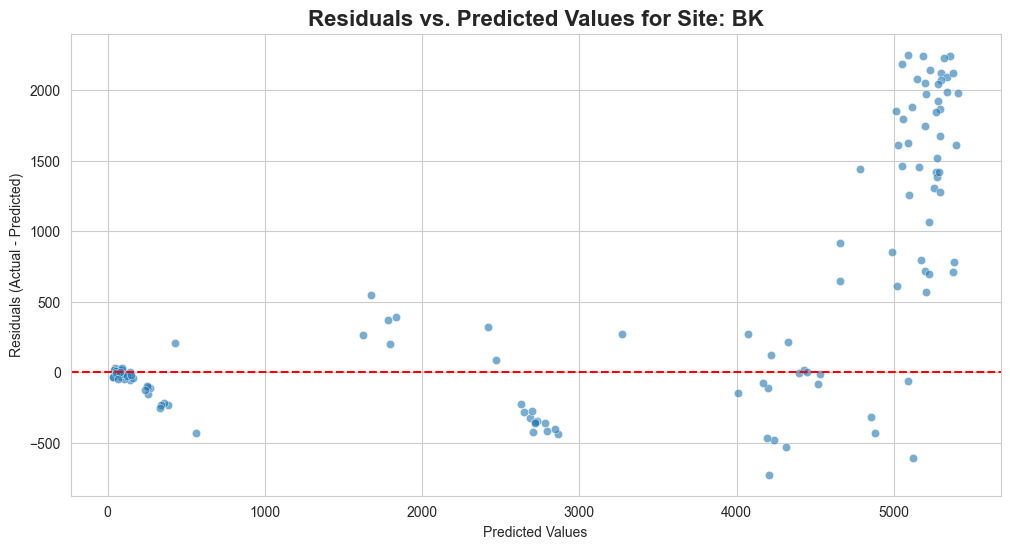

--> Generating SHAP summary plot for feature explanation...


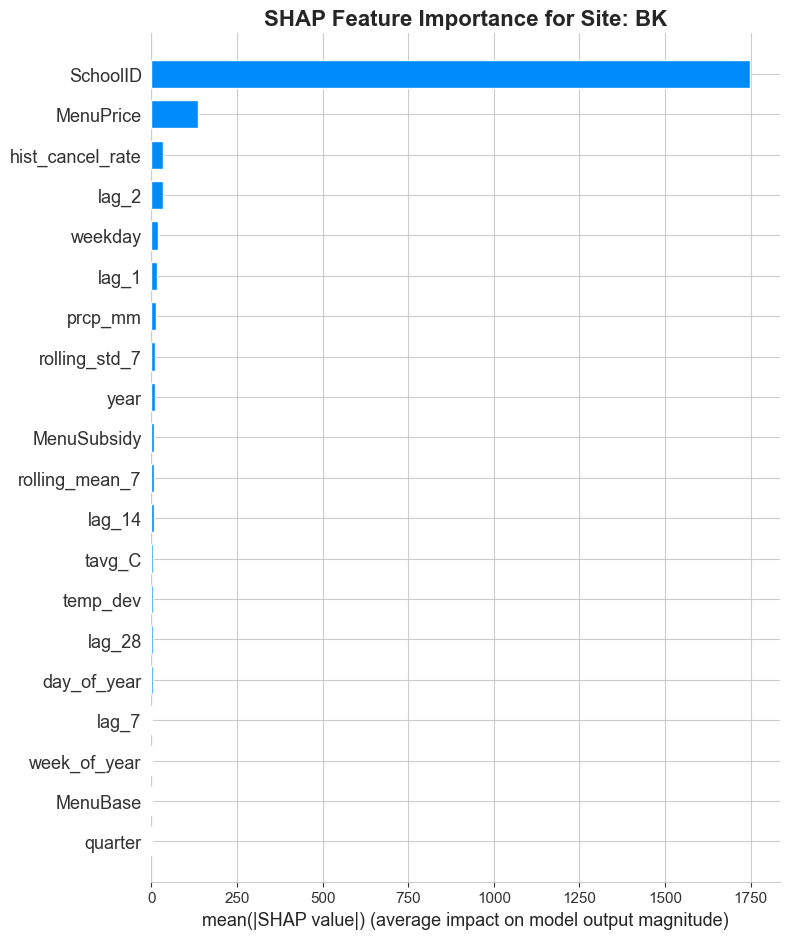


============================== Processing Site: LP ==============================
--> Evaluating model with time-series cross-validation...
    - Asymmetric Loss: 489.36 (+/- 175.58)
    - RMSE: 614.07 (+/- 127.95) meals
--> Fitting final pipeline on all data for this site...
--> Generating Actual vs. Predicted plot for the last fold...


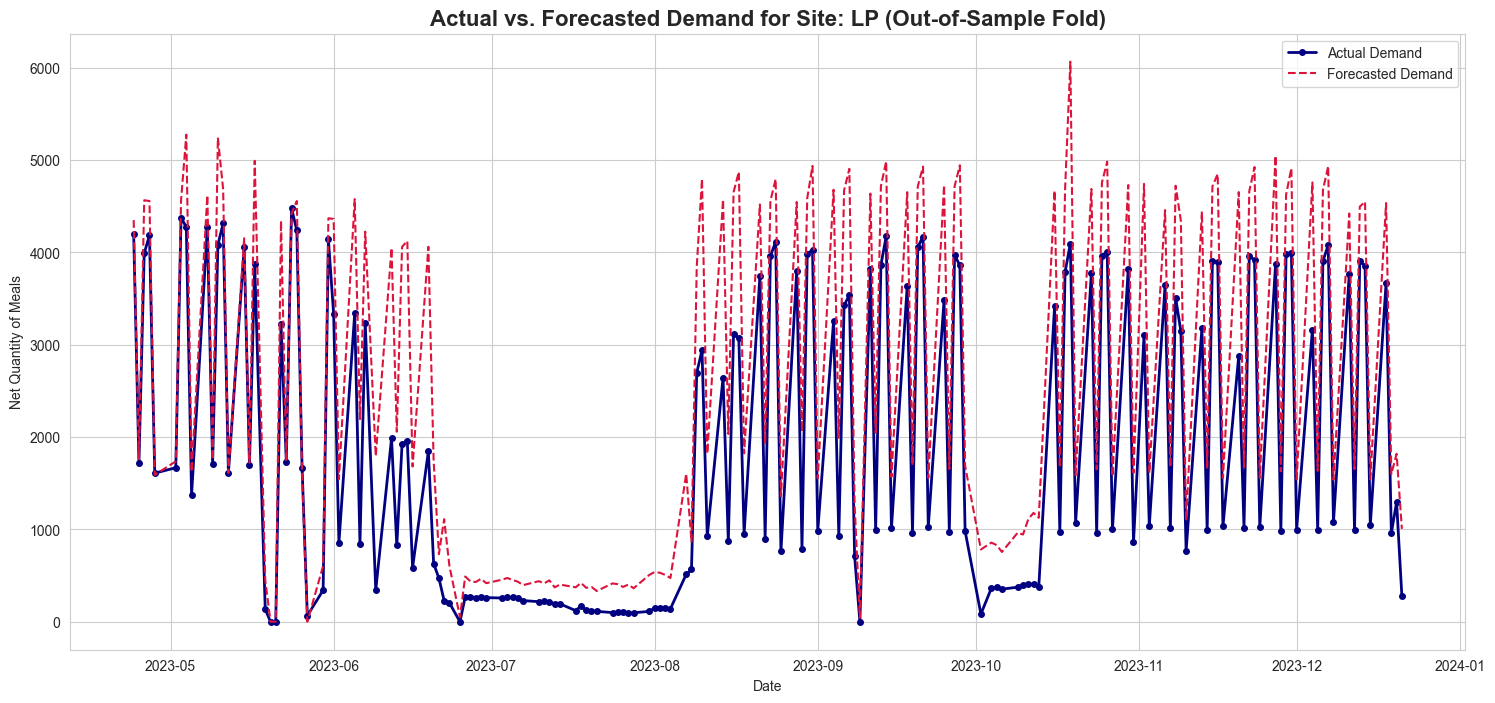

--> Generating Residuals plot...


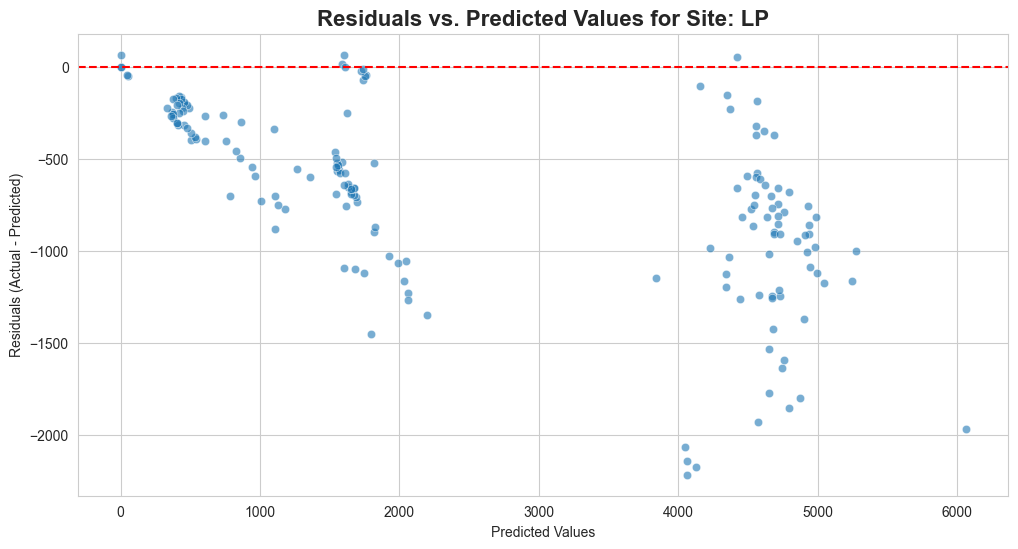

--> Generating SHAP summary plot for feature explanation...


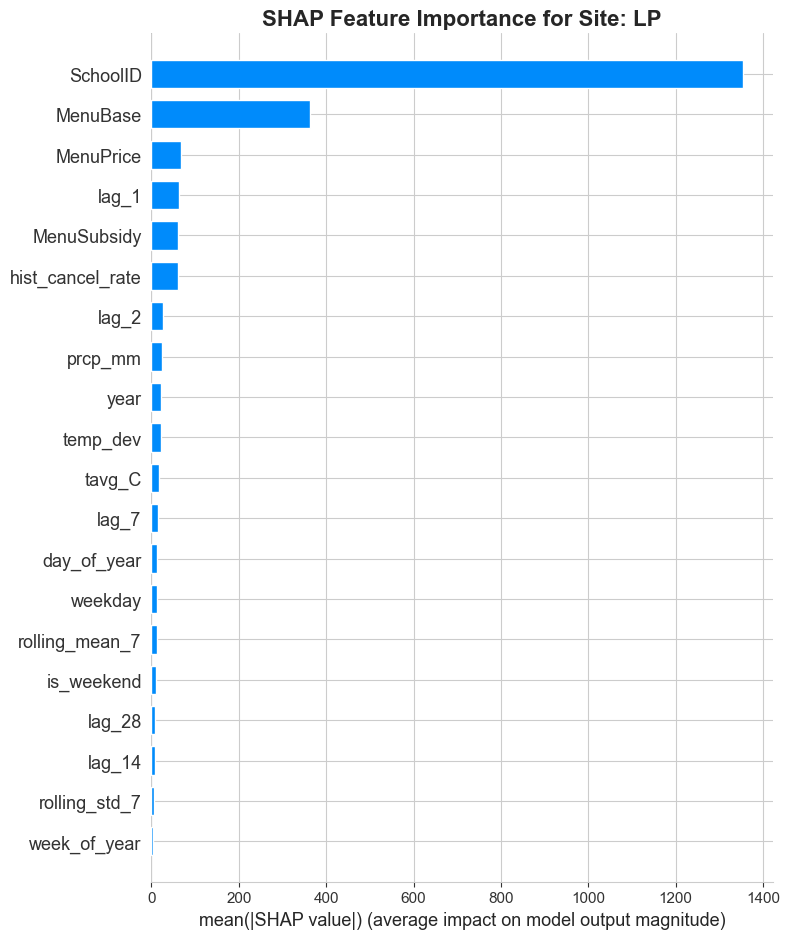


============================== Processing Site: MS ==============================
--> Evaluating model with time-series cross-validation...
    - Asymmetric Loss: 303.78 (+/- 368.52)
    - RMSE: 369.65 (+/- 462.58) meals
--> Fitting final pipeline on all data for this site...
--> Generating Actual vs. Predicted plot for the last fold...


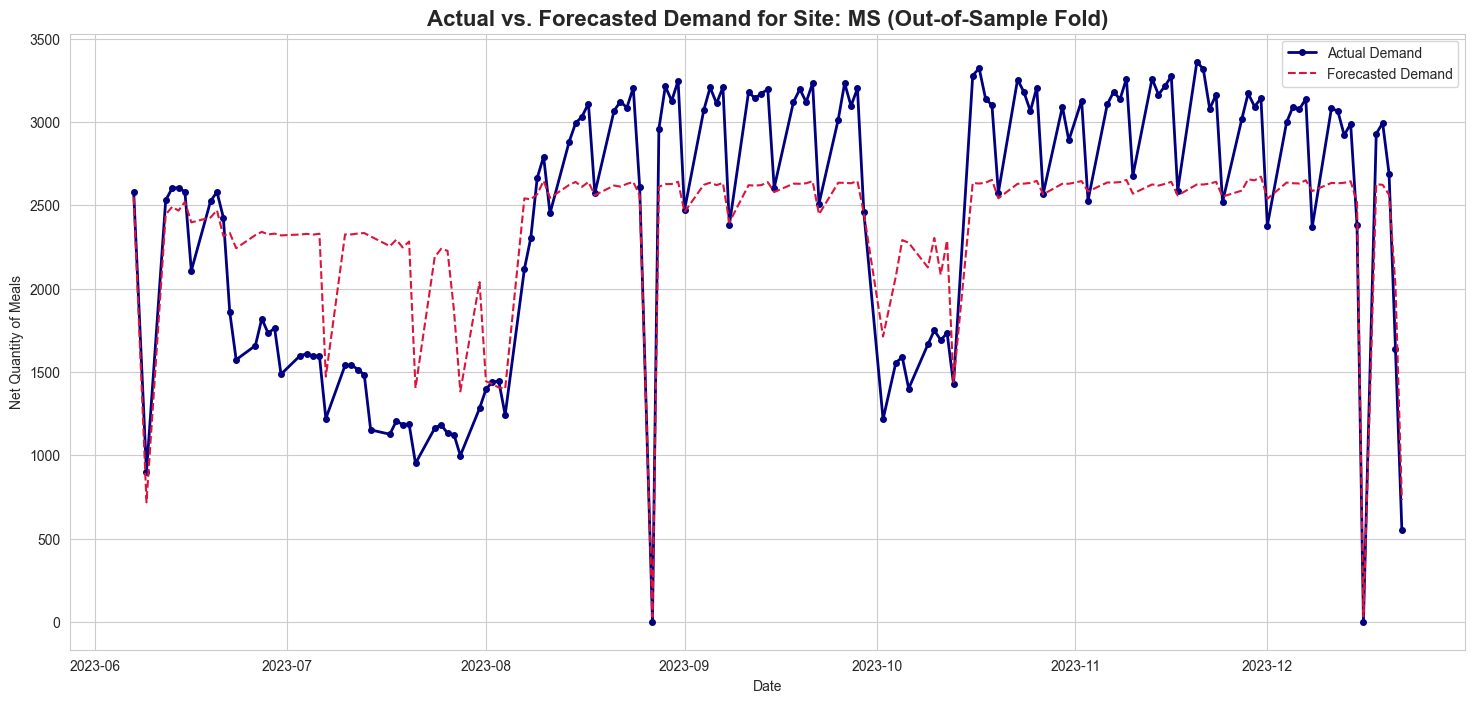

--> Generating Residuals plot...


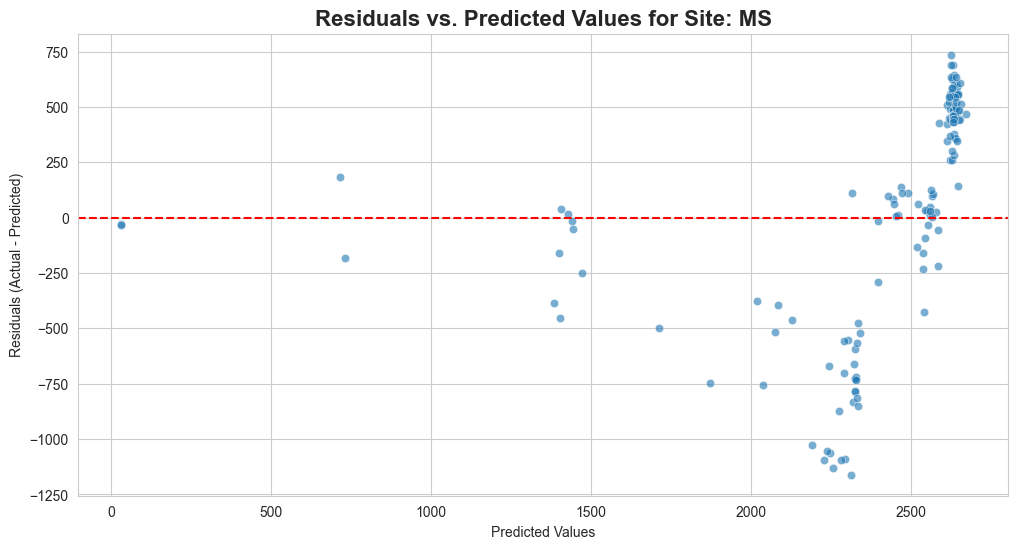

--> Generating SHAP summary plot for feature explanation...


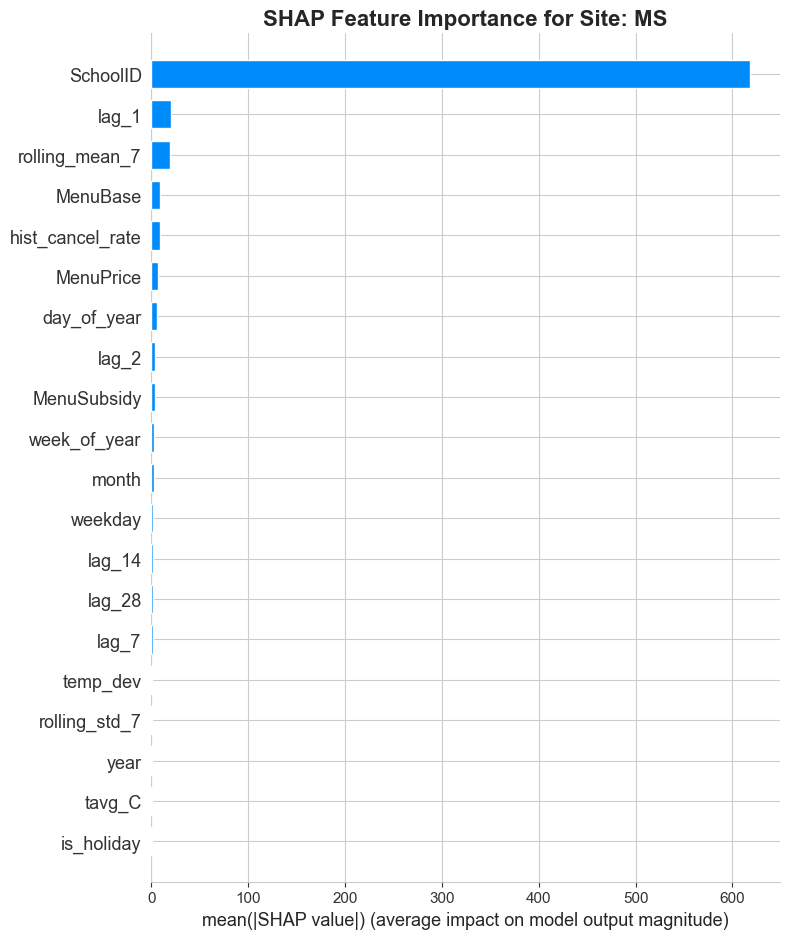


PART 4 Complete: All sites have been trained, evaluated, and visualized.


In [8]:


# =============================================================================
# PART 4: PER-SITE MODEL TRAINING, EVALUATION, AND VISUALIZATION
# -----------------------------------------------------------------------------
# This is the main execution block. It loops through each kitchen site,
# uses the pipeline defined in Part 3 to train and evaluate the model using
# time-series cross-validation, and generates detailed visualizations
# for each site's performance.
# =============================================================================

print("\nPART 4: Starting model training and evaluation for each site...")

sites = df_daily['Site'].unique()
all_scores = {}
fitted_pipelines = {}
baseline_scores = {}
for site in sites:
    print(f"\n{'='*30} Processing Site: {site} {'='*30}")

    # Prepare data for the current site
    df_site = df_daily[df_daily['Site'] == site].copy()

    # The pipeline will handle feature creation, imputation, and dropping internally.
    # We pass the full site-specific DataFrame to it.
    X = df_site
    y = df_site['net_qty']

    if len(X) < 100: # A reasonable threshold for robust cross-validation
        print(f"Skipping site {site} due to insufficient data ({len(X)} daily records).")
        continue

    # Use TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # --- Evaluate Model with Cross-Validation ---
    print("--> Evaluating model with time-series cross-validation...")
    # Note: `cross_val_score` returns negative values for loss/error-based scorers.
    # We multiply by -1 to make them positive and interpretable.
    custom_scores = -cross_val_score(regression_pipeline, X, y, cv=tscv, scoring=asymmetric_scorer, n_jobs=-1)
    rmse_scores = -cross_val_score(regression_pipeline, X, y, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    baseline_scores[site] = {'Asymmetric Loss': custom_scores.mean(), 'RMSE': rmse_scores.mean()}
    all_scores[site] = {
        'Asymmetric Loss': f"{custom_scores.mean():.2f} (+/- {custom_scores.std():.2f})",
        'RMSE': f"{rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})"
    }
    print(f"    - Asymmetric Loss: {all_scores[site]['Asymmetric Loss']}")
    print(f"    - RMSE: {all_scores[site]['RMSE']} meals")

    # --- Fit Final Pipeline for Visualization ---
    print("--> Fitting final pipeline on all data for this site...")
    final_pipeline = regression_pipeline.fit(X, y)
    fitted_pipelines[site] = final_pipeline

    # --- Generate Visualizations for the Last CV Fold ---
    # This provides a true out-of-sample performance view.
    train_indices, test_indices = list(tscv.split(X))[-1]
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    # Fit a temporary pipeline on the training part of the fold
    vis_pipeline = regression_pipeline.fit(X_train, y_train)
    predictions = vis_pipeline.predict(X_test)

    # Plot 4: Actual vs. Predicted Plot
    print("--> Generating Actual vs. Predicted plot for the last fold...")
    plt.figure(figsize=(18, 8))
    plt.plot(y_test.index, y_test, label='Actual Demand', color='navy', lw=2, marker='o', markersize=4, linestyle='-')
    plt.plot(y_test.index, predictions, label='Forecasted Demand', color='crimson', linestyle='--')
    plt.title(f'Actual vs. Forecasted Demand for Site: {site} (Out-of-Sample Fold)', fontsize=16, weight='bold')
    plt.ylabel('Net Quantity of Meals')
    plt.xlabel('Date')
    plt.legend()
    plt.show()

    # Plot 5: Residuals Plot
    print("--> Generating Residuals plot...")
    residuals = y_test - predictions
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=predictions, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals vs. Predicted Values for Site: {site}', fontsize=16, weight='bold')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.show()

    # --- SHAP Analysis for Feature Importance ---
    # This explains the output of the model fitted on the full site data.
    print("--> Generating SHAP summary plot for feature explanation...")

    # We need to get the transformed data from the pipeline to feed to SHAP
    processed_X = final_pipeline.named_steps['dropper'].transform(
        final_pipeline.named_steps['imputer'].transform(
            final_pipeline.named_steps['daily_features'].transform(X)
        )
    )
    regressor = final_pipeline.named_steps['regressor']

    # Initialize and run the SHAP explainer
    explainer = shap.TreeExplainer(regressor)
    shap_values = explainer.shap_values(processed_X)

    # Plot 6: SHAP Summary Plot
    plt.title(f'SHAP Feature Importance for Site: {site}', fontsize=16, weight='bold')
    shap.summary_plot(shap_values, processed_X, plot_type="bar", show=False)
    plt.show()


print("\nPART 4 Complete: All sites have been trained, evaluated, and visualized.")


In [9]:

# =============================================================================
# PART 5: HYPERPARAMETER TUNING AND FINAL MODEL EVALUATION
# -----------------------------------------------------------------------------
# This final part uses RandomizedSearchCV to find the best settings for our
# RandomForestRegressor, aiming to improve upon the baseline performance.
# The results of the best model are then presented.
# =============================================================================

print("\nPART 5: Starting hyperparameter tuning with RandomizedSearchCV...")

# Define the parameter grid for the RandomForestRegressor
# These are the settings we want to test.
param_dist = {
    'regressor__n_estimators': [100, 200, 300, 500],
    'regressor__max_features': ['sqrt', 'log2', 0.7, 0.8],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__bootstrap': [True, False]
}

tuned_scores = {}
best_models = {}

for site in sites:
    print(f"\n{'='*30} Tuning for Site: {site} {'='*30}")
    df_site = df_daily[df_daily['Site'] == site].copy()
    X, y = df_site, df_site['net_qty']

    if len(X) < 100:
        print(f"Skipping site {site} due to insufficient data.")
        continue

    tscv = TimeSeriesSplit(n_splits=5)

    # Set up the search
    # n_iter=50 means it will try 50 different random combinations of parameters.
    # refit=True ensures the best found model is re-trained on all the data.
    search = RandomizedSearchCV(
        estimator=regression_pipeline,
        param_distributions=param_dist,
        n_iter=50,
        cv=tscv,
        scoring=asymmetric_scorer, # We optimize for our custom business metric
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )

    # Run the search
    search.fit(X, y)

    # Store the best pipeline and its score
    best_models[site] = search.best_estimator_
    # The score is negative, so we multiply by -1
    best_score = -search.best_score_

    # Also calculate the RMSE for the best model for interpretability
    best_pipeline = search.best_estimator_
    tuned_rmse = -cross_val_score(best_pipeline, X, y, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

    tuned_scores[site] = {'Asymmetric Loss': best_score, 'RMSE': tuned_rmse}

    print(f"--> Best Tuned Asymmetric Loss for {site}: {best_score:.2f}")
    print(f"--> Best Tuned RMSE for {site}: {tuned_rmse:.2f} meals")
    print("--> Best Parameters Found:")
    # Display the best parameters in a readable format
    for param, value in search.best_params_.items():
        print(f"    - {param}: {value}")


# --- Final Summary Table ---
print(f"\n\n{'='*30} FINAL PERFORMANCE SUMMARY {'='*30}")
baseline_df = pd.DataFrame(baseline_scores).T.rename(columns=lambda c: f"Baseline {c}")
tuned_df = pd.DataFrame(tuned_scores).T.rename(columns=lambda c: f"Tuned {c}")

final_summary = pd.concat([baseline_df, tuned_df], axis=1)
print("Comparison of Baseline vs. Tuned Model Performance:")
display(final_summary)

print("\nPART 5 Complete: Hyperparameter tuning finished and final results compiled.")


PART 5: Starting hyperparameter tuning with RandomizedSearchCV...

============================== Tuning for Site: BK ==============================
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Best Tuned Asymmetric Loss for BK: 407.94
--> Best Tuned RMSE for BK: 550.91 meals
--> Best Parameters Found:
    - regressor__n_estimators: 200
    - regressor__min_samples_split: 2
    - regressor__min_samples_leaf: 2
    - regressor__max_features: 0.8
    - regressor__max_depth: 10
    - regressor__bootstrap: True

============================== Tuning for Site: LP ==============================
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Best Tuned Asymmetric Loss for LP: 464.03
--> Best Tuned RMSE for LP: 558.20 meals
--> Best Parameters Found:
    - regressor__n_estimators: 200
    - regressor__min_samples_split: 5
    - regressor__min_samples_leaf: 4
    - regressor__max_features: 0.7
    - regressor__max_depth: None
    - regressor__bootstrap: 

,Baseline Asymmetric Loss,Baseline RMSE,Tuned Asymmetric Loss,Tuned RMSE
BK,374.706451,506.463800,407.944767,550.906406
LP,489.360821,614.071007,464.028056,558.204411
MS,303.778020,369.650059,280.306941,344.011948



PART 5 Complete: Hyperparameter tuning finished and final results compiled.


In [15]:

# =============================================================================
# PART 6: ADVANCED FEATURE ENGINEERING (FIXED)
# -----------------------------------------------------------------------------
# To fix the error, we now perform the advanced feature engineering as a
# separate, explicit step BEFORE the final modeling pipeline. This ensures
# that the data passed to cross_val_score has a consistent number of samples.
# =============================================================================

print("\nPART 6: Performing advanced feature engineering...")

# Step 1: Create order-level features using your transformers on the original 'df'
print("--> Step 6.1: Creating order-level features (hist_rate, clusters)...")
hist_transformer = HistCancelRateTransformer(group_keys=('Site', 'MenuBase'), value_col='net_qty')
df_adv = hist_transformer.fit_transform(df)

cluster_transformer = ClusterTransformer(
    profile_feats=['hist_cancel_rate', 'rain_flag', 'temp_dev', 'MenuPrice', 'MenuSubsidy'],
    group_keys=('Site', 'MenuBase'), n_clusters=5
)
df_adv = cluster_transformer.fit_transform(df_adv)
print("    ...done. New columns 'hist_cancel_rate' and 'cluster_id' created.")
display(df_adv[['Site', 'MenuBase', 'hist_cancel_rate', 'cluster_id']].head())

# Step 2: Aggregate the newly enriched data to the daily level
print("--> Step 6.2: Aggregating enriched data to daily level...")
adv_agg_dict = agg_dict.copy()
adv_agg_dict['cluster_id'] = pd.Series.mode # Use the most frequent cluster of the day
# We already have hist_cancel_rate in the agg_dict, which will now use the new values

df_daily_adv = df_adv.groupby(['DateOfService', 'Site']).agg(adv_agg_dict).reset_index()
# Handle cases where mode returns multiple values
df_daily_adv['cluster_id'] = df_daily_adv['cluster_id'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)
df_daily_adv = df_daily_adv.sort_values('DateOfService').set_index('DateOfService')
print("    ...done. Advanced daily dataset is ready for modeling.")
display(df_daily_adv.head())

print("\nPART 6 Complete: Advanced feature set created.")




PART 6: Performing advanced feature engineering...
--> Step 6.1: Creating order-level features (hist_rate, clusters)...
    ...done. New columns 'hist_cancel_rate' and 'cluster_id' created.


,Site,MenuBase,hist_cancel_rate,cluster_id
0,LP,MITTAGESSEN,1.0499,0
1,LP,MITTAGESSEN,1.0499,0
2,LP,MITTAGESSEN,1.0499,0
3,LP,MITTAGESSEN,1.0499,0
4,LP,MITTAGESSEN,1.0499,0


--> Step 6.2: Aggregating enriched data to daily level...
    ...done. Advanced daily dataset is ready for modeling.


,Site,net_qty,OrderQty,CanceledQty,MenuPrice,MenuSubsidy,tavg_C,prcp_mm,rain_flag,temp_dev,is_holiday,is_weekend,MenuBase,SchoolID,hist_cancel_rate,cluster_id
DateOfService,,,,,,,,,,,,,,,,
2020-01-02,BK,32,32,0,1.812500,1.687500,1.2,0.0,0,-2.957672,0,0,1,1,0.979676,4
2020-01-02,LP,169,169,0,2.832530,0.240964,0.3,0.0,0,-3.965782,1,1,1,2,1.049900,0
2020-01-03,BK,32,32,0,1.993750,1.506250,6.8,201.6,1,2.642328,0,0,1,1,0.979676,4
2020-01-03,LP,184,184,0,2.714088,0.334530,6.7,886.9,1,2.434218,1,1,1,2,1.049900,0
2020-01-04,LP,1,1,0,0.000000,3.500000,4.7,5.1,1,0.434218,0,0,1,1,1.049900,0



PART 6 Complete: Advanced feature set created.



PART 7: Building and evaluating an advanced pipeline with LightGBM...

============================== Evaluating Advanced Model for Site: BK ==============================
    - Advanced Asymmetric Loss: 362.32
    - Advanced RMSE: 492.62 meals

============================== Evaluating Advanced Model for Site: LP ==============================
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 136, number of used features: 23
[LightGBM] [Info] Start training from score 2261.485294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

,Baseline RF Asymmetric Loss,Baseline RF RMSE,Tuned RF Asymmetric Loss,Tuned RF RMSE,Advanced LGBM Asymmetric Loss,Advanced LGBM RMSE
BK,374.706451,506.463800,407.944767,550.906406,362.323782,492.620718
LP,489.360821,614.071007,464.028056,558.204411,520.042625,604.721188
MS,303.778020,369.650059,280.306941,344.011948,329.068697,390.582675


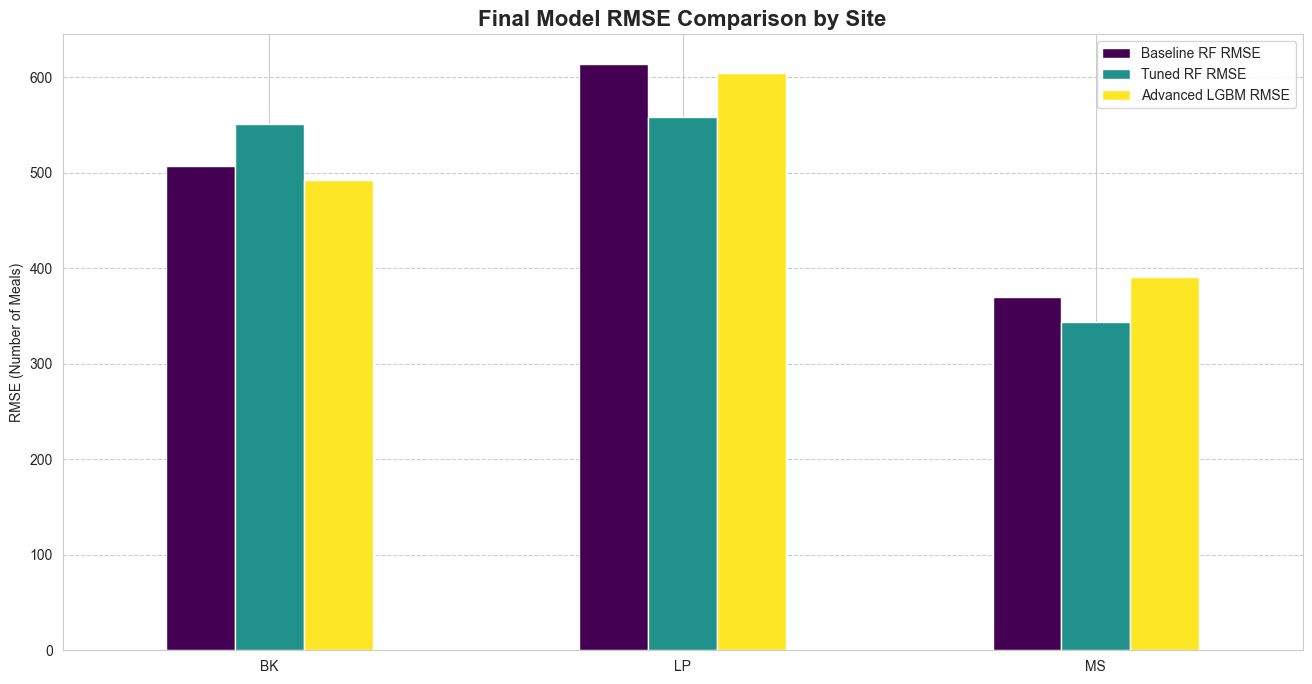


SCRIPT COMPLETE: Advanced model evaluated and final comparison generated.


In [16]:
from lightgbm import LGBMRegressor

# =============================================================================
# PART 7: ADVANCED MODEL TRAINING & FINAL COMPARISON (FIXED)
# -----------------------------------------------------------------------------
# This part now uses the pre-processed advanced daily dataset (`df_daily_adv`)
# with a simpler pipeline that doesn't need to do the aggregation itself.
# =============================================================================

print("\nPART 7: Building and evaluating an advanced pipeline with LightGBM...")

# --- Define the NEW Advanced Pipeline ---
# This pipeline is simpler because the complex feature creation was done in Part 6.
features_to_exclude_adv = features_to_exclude + ['MenuBase'] # MenuBase is not in daily data
advanced_pipeline_lgbm = Pipeline([
    ('daily_features', DailyFeatureEngineer()),
    ('imputer', MissingFlagImputer(strategy='median')),
    ('dropper', ColumnDropper(cols_to_drop=features_to_exclude_adv)),
    ('regressor', LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

advanced_scores = {}
for site in sites:
    print(f"\n{'='*30} Evaluating Advanced Model for Site: {site} {'='*30}")

    # Use the new advanced daily dataframe
    df_site_adv = df_daily_adv[df_daily_adv['Site'] == site].copy()
    X, y = df_site_adv, df_site_adv['net_qty']

    if len(X) < 100:
        print(f"Skipping site {site} due to insufficient data.")
        continue

    # Now X and y have the same length, and the ValueError is resolved.
    tscv = TimeSeriesSplit(n_splits=5)
    adv_custom_scores = -cross_val_score(advanced_pipeline_lgbm, X, y, cv=tscv, scoring=asymmetric_scorer, n_jobs=-1)
    adv_rmse_scores = -cross_val_score(advanced_pipeline_lgbm, X, y, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)

    advanced_scores[site] = {'Asymmetric Loss': adv_custom_scores.mean(), 'RMSE': adv_rmse_scores.mean()}
    print(f"    - Advanced Asymmetric Loss: {adv_custom_scores.mean():.2f}")
    print(f"    - Advanced RMSE: {adv_rmse_scores.mean():.2f} meals")


# --- Final Summary Table with Advanced Model ---
print(f"\n\n{'='*30} FINAL PERFORMANCE SUMMARY {'='*30}")
baseline_df = pd.DataFrame(baseline_scores).T.rename(columns=lambda c: f"Baseline RF {c}")
tuned_df = pd.DataFrame(tuned_scores).T.rename(columns=lambda c: f"Tuned RF {c}")
advanced_df = pd.DataFrame(advanced_scores).T.rename(columns=lambda c: f"Advanced LGBM {c}")

final_summary = pd.concat([baseline_df, tuned_df, advanced_df], axis=1)
print("Comparison of Baseline vs. Tuned vs. Advanced Model Performance:")
display(final_summary)

# Plotting the final comparison
final_summary_plot = final_summary[[col for col in final_summary.columns if 'RMSE' in col]]
final_summary_plot.plot(kind='bar', figsize=(16, 8), colormap='viridis')
plt.title('Final Model RMSE Comparison by Site', fontsize=16, weight='bold')
plt.ylabel('RMSE (Number of Meals)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

print("\nSCRIPT COMPLETE: Advanced model evaluated and final comparison generated.")
